**Imports and initial setup**

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=6e5d635850fc6440e663aa7d6da5d599be693e0cae1010c4a5e7065a8785840b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
!pip install --upgrade spacy

     |████████████████████████████████| 6.0 MB 3.8 MB/s 
     |████████████████████████████████| 10.1 MB 45.2 MB/s 
     |████████████████████████████████| 181 kB 19.2 MB/s 
     |████████████████████████████████| 457 kB 11.0 MB/s 
     |████████████████████████████████| 653 kB 46.8 MB/s 
     |████████████████████████████████| 42 kB 281 kB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.

In [ ]:
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     |████████████████████████████████| 13.9 MB 5.3 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
Yo

In [ ]:
import pandas as pd
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string, strip_multiple_whitespaces, strip_tags, strip_punctuation, remove_stopwords
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models import TfidfModel
from gensim.models.phrases import Phraser

import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt

import spacy

import warnings
warnings.filterwarnings('ignore')

# MOVIE_FILE = "IMDb_TLJ_Reviews.csv"
MOVIE_FILE = "IMDb_TSR_Reviews.csv"
NEGATIVE_THRESHOLD = 4.0

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


**Preparing negative review data**

In [ ]:
df = pd.read_csv(MOVIE_FILE, index_col=0)
print(df.head())
print(df.info())

                                             Reviews  Scores
0  Why do I want to write the 234th comment on Th...    10.0
1  The Shawshank Redemption is written and direct...    10.0
2  In its Oscar year, Shawshank Redemption (writt...    10.0
3  This movie is not your ordinary Hollywood flic...    10.0
4  I'm trying to save you money; this is the last...    10.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10086 entries, 0 to 10085
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Reviews  10086 non-null  object 
 1   Scores   9522 non-null   float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB
None


In [ ]:
# extracting negative reviews from dataset
df_neg = df[df['Scores'] <= NEGATIVE_THRESHOLD]
print(df_neg.tail())
print(df_neg.info())

# collecting all reviews in a list

data = df.Reviews.values.tolist()
# data = df_neg.Reviews.values.tolist() 


                                                 Reviews  Scores
9846   After watching this i realialize that its a no...     3.0
9866   Not the best but it was an ok movie definetly ...     3.0
9878   Very fantastic movie i liked it sooooooooooooo...     3.0
10006  Good movie..seen multiple times can be watched...     4.0
10072  Kinda Boring i dont like the actors much and t...     4.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 70 to 10072
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Reviews  260 non-null    object 
 1   Scores   260 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.1+ KB
None


In [ ]:
from re import IGNORECASE
# preprocessing review data
N_GRAM_THRESHOLD = 500
CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, remove_stopwords, strip_multiple_whitespaces]
ALLOWED_POSTAGS = ['NOUN', 'ADJ',] # 'VERB', 'ADV'
IGNORE_WORDS = ["movie", "matrix", "t", "film", "thing", "shawshank", "redemption"]

pdata = [preprocess_string(str(review), filters=CUSTOM_FILTERS) for review in data] # https://radimrehurek.com/gensim/parsing/preprocessing.html

# sample result
print(f"Raw: {data[0]}")
print(f"Preprocessed: {pdata[0]}")

bigram = Phrases(pdata, min_count=10, threshold=N_GRAM_THRESHOLD) 
trigram = Phrases(bigram[pdata], min_count=10, threshold=N_GRAM_THRESHOLD)  

# export bigram and trigram models. They cannot be updated after this step
bigram_model = Phraser(bigram)
trigram_model = Phraser(trigram)

# sample result
def display_n_gram(review, n=2):
  n_grams = list()

  if n == 2:
    review = bigram_model[review]
  if n == 3:
    review = trigram_model[bigram_model[review]]
    
  for word in review:
    if word.count("_") == n-1:
      n_grams.append(word)
  return n_grams

print(f"Bigram in first review: {display_n_gram(pdata[0], 2)}")
print(f"Trigram in first review: {display_n_gram(pdata[0], 3)}")

pdata_bigrams = [bigram_model[review] for review in pdata]
pdata_trigrams = [trigram_model[bigram_model[review]] for review in pdata]

def lemmatization(texts, allowed_postags):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # load only the tagger tokenizer
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        tokenized_sent = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        tokenized_sent = [token for token in tokenized_sent if token not in IGNORE_WORDS] 
        texts_out.append(tokenized_sent)
    return texts_out

pdata_lemmatized = lemmatization(pdata_bigrams,allowed_postags=ALLOWED_POSTAGS)
print(f"Lemmatized review: {pdata_lemmatized[0]}")




Raw: Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this movie at all: I do not like prison movies and I don't normally watch them. I work at a branch library and one day as I was checking The Shawshank Redemption out to one of our older patrons, she said to me, "Whenever I feel down or depressed, I check out this movie and watch it and it always makes me feel better." At the time, I thought that was very strange. One day there was nothing on TV except things I absolutely would not watch under any circumstance or things that I had seen too many times a

In [ ]:
len(pdata_lemmatized)
index = 30
print(f"Raw: {data[index]}")
print(f"Preprocessed: {pdata[index]}")
print(f"Bigram in first review: {display_n_gram(pdata[index], 2)}")
print(f"Trigram in first review: {display_n_gram(pdata[index], 3)}")
print(f"Lemmatized review: {pdata_lemmatized[index]}")

Raw: "The Shawshank Redemption" should have won Best Picture for 1994. A story of banker Andy Dufresne (Tim Robbins) getting falsely convicted of murder and sent to the hellish Shawshank prison, the movie is beyond amazing. In prison, Andy meets Ellis Boyd "Red" Redding (Morgan Freeman), who was imprisoned many years earlier. Red gets Andy a poster of Rita Hayworth. Over the next twenty years, Andy experiences all the horrors that one would expect in jail: beatings by the guards, rapes by other inmates, and so on. But he never gives up hope.This movie, like "Carrie", "The Shining", "Dolores Claiborne", "The Green Mile" and "Hearts in Atlantis", just goes to show what a great author Stephen King is. When we think of horror, we think of spooky horror, but "The Shawshank Redemption" is a different kind: personal horror. Pure genius. I can only hope that in the coming years, this movie is recognized as what it is: a masterpiece. I can't believe that it won no Oscars!
Preprocessed: ['shawsh

**Topic Modelling: LDA with BOW**

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(pdata_lemmatized) # word to ID mapping

# Term Document Frequency - Bag of words
corpus = [id2word.doc2bow(review) for review in pdata_lemmatized] #  list of (token_id, token_count)

print("Bag of words for first review:")
for token_id, token_count in corpus[30]:
  print(f"{id2word[token_id]}: {token_count}")

Bag of words for first review:
good: 1
hope: 2
prison: 2
banker: 1
great: 1
heart: 1
inmate: 1
story: 1
amazing: 1
picture: 1
red: 2
year: 3
ellis_boyd: 1
kind: 1
oscar: 1
personal: 1
different: 1
author: 1
horror: 4
murder: 1
masterpiece: 1
beating: 1
carrie: 1
dolore: 1
early: 1
genius: 1
green_mile: 1
guard: 1
jail: 1
poster: 1
pure: 1
rape: 1


**Frequency distribution of tokens in all reviews**

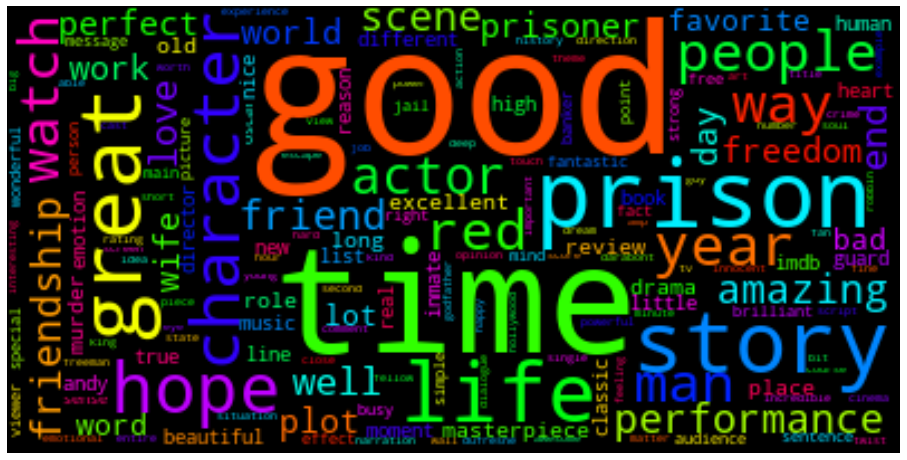

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = [item for sublist in pdata_lemmatized for item in sublist]
dictionary=Counter(all_words)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Train LDA Model**

In [ ]:
lda_model_s8 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           update_every=1,
                                           chunksize=1000,
                                            passes=100,
                                            iterations=20)
                                          #  passes=10
                                          #  alpha='auto',
                                          #  per_word_topics=True)

KeyboardInterrupt: ignored

In [ ]:
lda_model_s20 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           update_every=1,
                                           chunksize=1000,
                                            passes=100,
                                            iterations=20)
                                          #  passes=10
                                          #  alpha='auto',
                                          #  per_word_topics=True)

In [ ]:
lda_model_s15 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           update_every=1,
                                           chunksize=1000,
                                            passes=100,
                                            iterations=20)
                                          #  passes=10
                                          #  alpha='auto',
                                          #  per_word_topics=True)

In [ ]:
print(lda_model_s8.print_topics())
# Compute Perplexity
print('\nPerplexity: ', lda_model_s8.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_s8, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.055*"prison" + 0.045*"life" + 0.026*"hope" + 0.019*"man" + 0.018*"red" + 0.016*"thing" + 0.013*"prisoner" + 0.011*"freedom" + 0.010*"people" + 0.009*"story"'), (1, '0.046*"shawshank" + 0.045*"amazing" + 0.032*"favorite" + 0.028*"dream" + 0.028*"redemption" + 0.028*"need" + 0.027*"sway" + 0.026*"great" + 0.026*"hope" + 0.025*"cool"'), (2, '0.041*"time" + 0.041*"good" + 0.026*"story" + 0.024*"redemption" + 0.021*"great" + 0.019*"shawshank" + 0.015*"character" + 0.013*"watch" + 0.009*"prison" + 0.009*"actor"'), (3, '0.022*"shawshank" + 0.020*"art" + 0.019*"redemption" + 0.013*"book" + 0.013*"hope" + 0.013*"darabont" + 0.012*"novella" + 0.012*"prison" + 0.012*"hollywood" + 0.011*"audience"'), (4, '0.049*"prison" + 0.033*"red" + 0.023*"shawshank" + 0.023*"life" + 0.018*"redemption" + 0.017*"time" + 0.017*"story" + 0.016*"andy" + 0.013*"way" + 0.013*"friend"'), (5, '0.290*"good" + 0.108*"great" + 0.033*"watch" + 0.028*"time" + 0.026*"love" + 0.023*"awesome" + 0.023*"nice" + 0.022*"ac

In [ ]:
print(lda_model.print_topics())
# Compute Perplexity
print('\nPerplexity: ', lda_model_s20.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_s20, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.055*"prison" + 0.045*"life" + 0.026*"hope" + 0.019*"man" + 0.018*"red" + 0.016*"thing" + 0.013*"prisoner" + 0.011*"freedom" + 0.010*"people" + 0.009*"story"'), (1, '0.046*"shawshank" + 0.045*"amazing" + 0.032*"favorite" + 0.028*"dream" + 0.028*"redemption" + 0.028*"need" + 0.027*"sway" + 0.026*"great" + 0.026*"hope" + 0.025*"cool"'), (2, '0.041*"time" + 0.041*"good" + 0.026*"story" + 0.024*"redemption" + 0.021*"great" + 0.019*"shawshank" + 0.015*"character" + 0.013*"watch" + 0.009*"prison" + 0.009*"actor"'), (3, '0.022*"shawshank" + 0.020*"art" + 0.019*"redemption" + 0.013*"book" + 0.013*"hope" + 0.013*"darabont" + 0.012*"novella" + 0.012*"prison" + 0.012*"hollywood" + 0.011*"audience"'), (4, '0.049*"prison" + 0.033*"red" + 0.023*"shawshank" + 0.023*"life" + 0.018*"redemption" + 0.017*"time" + 0.017*"story" + 0.016*"andy" + 0.013*"way" + 0.013*"friend"'), (5, '0.290*"good" + 0.108*"great" + 0.033*"watch" + 0.028*"time" + 0.026*"love" + 0.023*"awesome" + 0.023*"nice" + 0.022*"ac

In [ ]:
print(lda_model_s15.print_topics())
# Compute Perplexity
print('\nPerplexity: ', lda_model_s15.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_s15, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.252*"nice" + 0.028*"perception" + 0.015*"suspenseful" + 0.014*"representation" + 0.008*"able" + 0.008*"detainee" + 0.007*"fond" + 0.006*"manipulation" + 0.005*"supper" + 0.005*"priority"'), (1, '0.259*"review" + 0.039*"site" + 0.025*"english" + 0.025*"original" + 0.023*"business" + 0.023*"break" + 0.021*"impressed" + 0.020*"line" + 0.015*"submission" + 0.015*"paragraph"'), (2, '0.331*"good" + 0.059*"redemption" + 0.050*"time" + 0.048*"shawshank" + 0.031*"watch" + 0.029*"prison" + 0.028*"well" + 0.026*"thing" + 0.016*"people" + 0.013*"man"'), (3, '0.061*"title" + 0.035*"shawshank" + 0.023*"single" + 0.021*"hour" + 0.021*"time" + 0.018*"effect" + 0.018*"today" + 0.017*"personal" + 0.017*"u" + 0.016*"humanity"'), (4, '0.058*"time" + 0.055*"good" + 0.049*"great" + 0.034*"story" + 0.022*"watch" + 0.017*"actor" + 0.013*"amazing" + 0.012*"year" + 0.012*"perfect" + 0.011*"redemption"'), (5, '0.063*"shawshank" + 0.049*"redemption" + 0.029*"great" + 0.029*"amazing" + 0.027*"hope" + 0.025

In [ ]:
# BOW on Shawshank Redemption 20 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_s20, corpus, id2word)
pyLDAvis.save_html(vis, 'lda_shawshank_20_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.190084 -0.213392       1        1  19.745085
9      0.177657  0.050660       2        1  16.387229
19     0.175421 -0.239399       3        1  10.452492
14     0.190195 -0.022315       4        1   9.004060
15     0.170877  0.235912       5        1   7.139457
13     0.071876  0.267838       6        1   6.552027
10     0.132125  0.014918       7        1   4.716432
2      0.107451 -0.138679       8        1   4.435924
8      0.076084 -0.007053       9        1   3.510891
3      0.137151  0.120453      10        1   2.955239
0      0.030709  0.102357      11        1   2.703808
12    -0.008797 -0.058641      12        1   2.225614
11     0.115355 -0.031129      13        1   2.211428
17    -0.185092 -0.056372      14        1   1.779319
16    -0.191205 -0.026591      15        1   1.556543
7     -0.226982  0.001438      16        1   1.285688
1     -0.233703 -0.000674      17        1   1.242522
4     -0.248522  0.005194      18        1   0.862772
18    -0.218435 -0.002914      19        1   0.779634
5     -0.262248 -0.001612      20        1   0.453837, topic_info=            Term         Freq        Total Category  logprob  loglift
9           good  9626.000000  9626.000000  Default  30.0000  30.0000
17        prison  6396.000000  6396.000000  Default  29.0000  29.0000
19     shawshank  4140.000000  4140.000000  Default  28.0000  28.0000
18    redemption  4387.000000  4387.000000  Default  27.0000  27.0000
26          time  6697.000000  6697.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
829     exercise     4.194322     5.203667  Topic20  -5.6822   5.1796
380       number   182.022814   374.626194  Topic20  -1.9118   4.6734
292         bond    35.448057   139.907511  Topic20  -3.5479   4.0223
1257    reminder     6.965028    14.700065  Topic20  -5.1750   4.6482
1135     instant     5.408531    22.649610  Topic20  -5.4280   3.9630

[1135 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3141     12  0.946672        10th
2458      8  0.955282  142_minute
3805     14  0.982018         1st
1500      8  0.367061          90
1500     16  0.596474          90
...     ...       ...         ...
258      10  0.073724        year
258      12  0.112646        year
658       5  0.983943       yearn
4148      4  0.973001           ¡
4149      4  0.960652           °

[1732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 20, 15, 16, 14, 11, 3, 9, 4, 1, 13, 12, 18, 17, 8, 2, 5, 19, 6])

In [ ]:
# BOW on Shawshank Redemption 15 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_s15, corpus, id2word)

pyLDAvis.save_html(vis, 'lda_shawshank_15_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.219889 -0.143885       1        1  27.268843
11    -0.150901 -0.113647       2        1  17.436731
6     -0.175174  0.185374       3        1  11.728232
7     -0.140901  0.133556       4        1   9.620003
14    -0.046875  0.037005       5        1   8.584844
2     -0.133311 -0.053033       6        1   4.917865
5     -0.075338 -0.110583       7        1   4.306286
9     -0.101933 -0.071901       8        1   4.033515
8     -0.062249 -0.007161       9        1   3.592684
13     0.070617  0.340006      10        1   2.623558
10     0.113157 -0.035429      11        1   2.350617
3      0.076642 -0.030718      12        1   1.368840
1      0.273147 -0.041077      13        1   1.004919
12     0.289031 -0.045775      14        1   0.722289
0      0.283978 -0.042733      15        1   0.440774, topic_info=             Term         Freq        Total Category  logprob  loglift
9            good  9199.000000  9199.000000  Default  30.0000  30.0000
17         prison  6366.000000  6366.000000  Default  29.0000  29.0000
93           life  4584.000000  4584.000000  Default  28.0000  28.0000
26           time  6684.000000  6684.000000  Default  27.0000  27.0000
19      shawshank  4180.000000  4180.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
789          able     9.738571   341.811701  Topic15  -4.8106   1.8662
12457   atrocious     0.059482     1.028045  Topic15  -9.9088   2.5747
12458    diatribe     0.059482     1.028045  Topic15  -9.9088   2.5747
1641   exposition     0.059482     1.028588  Topic15  -9.9088   2.5741
6873   acceptable     0.059482     1.028373  Topic15  -9.9088   2.5743

[891 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1500      2  0.982355              90
548       8  0.967274  ability_result
789       1  0.222345            able
789       2  0.333517            able
789       3  0.222345            able
...     ...       ...             ...
258       3  0.218545            year
258       5  0.327595            year
258      10  0.039010            year
258      11  0.018175            year
6031     10  0.987454     zihuatanejo

[1368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 7, 8, 15, 3, 6, 10, 9, 14, 11, 4, 2, 13, 1])

In [ ]:
# BOW on Shawshank Redemption
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda_shawshank_8_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.046972  0.165901       1        1  45.669003
0     -0.192394  0.100049       2        1  24.386880
4     -0.177227  0.082266       3        1   7.286575
7     -0.003676 -0.227376       4        1   7.127648
5      0.320234  0.130581       5        1   4.721038
3     -0.091956  0.037060       6        1   4.604914
6     -0.037784 -0.149620       7        1   4.436592
1      0.135832 -0.138861       8        1   1.767350, topic_info=          Term         Freq        Total Category  logprob  loglift
9         good  9215.000000  9215.000000  Default  30.0000  30.0000
80       great  4405.000000  4405.000000  Default  29.0000  29.0000
19   shawshank  4141.000000  4141.000000  Default  28.0000  28.0000
17      prison  6066.000000  6066.000000  Default  27.0000  27.0000
18  redemption  4365.000000  4365.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
10        hope   122.350881  3036.300768   Topic8  -3.6686   0.8242
50   character   113.013418  2659.906984   Topic8  -3.7479   0.8771
18  redemption   136.044771  4365.668784   Topic8  -3.5625   0.5671
80       great   122.994847  4405.182643   Topic8  -3.6633   0.4573
26        time    83.390664  6458.773423   Topic8  -4.0519  -0.3140

[537 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7637      8  0.820323             7th
1500      5  0.974839              90
548       6  0.979636  ability_result
404       1  0.907151          action
404       2  0.089228          action
...     ...       ...             ...
258       2  0.238275            year
258       3  0.116267            year
258       4  0.113874            year
6031      2  0.095171     zihuatanejo
6031      3  0.904125     zihuatanejo

[798 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 8, 6, 4, 7, 2])

In [ ]:
# BOW model on whole dataset. Notice how 1 and 2 lean towards positive and negative words
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.304002 -0.026737       1        1  40.052334
5     -0.300366 -0.017898       2        1  35.377410
2     -0.138229  0.168359       3        1  10.636938
1      0.065025 -0.299113       4        1   4.904715
4      0.171858  0.034234       5        1   2.539285
6      0.155524  0.048995       6        1   2.509373
7      0.167585  0.074175       7        1   2.316232
0      0.182604  0.017985       8        1   1.663713, topic_info=         Term         Freq        Total Category  logprob  loglift
24       film  3322.000000  3322.000000  Default  30.0000  30.0000
40      movie  9928.000000  9928.000000  Default  29.0000  29.0000
7         bad  2264.000000  2264.000000  Default  28.0000  28.0000
36     matrix  6804.000000  6804.000000  Default  27.0000  27.0000
161   trinity   762.000000   762.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
246    female     9.682608    73.582363   Topic8  -5.7220   2.0680
659      hard     9.370033   135.989161   Topic8  -5.7548   1.4211
1100   bright     7.867263    38.603201   Topic8  -5.9296   2.5055
2282        e     7.822854    41.482271   Topic8  -5.9353   2.4279
946     brain     7.559512    59.489018   Topic8  -5.9696   2.0331

[514 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5775      7  0.878378  150_character
588       4  0.978249            2nd
2535      2  0.575499            3rd
2535      4  0.402849            3rd
1         1  0.162015        ability
...     ...       ...            ...
5677      8  0.962152          youth
1174      1  0.101357           zion
1174      3  0.889689           zion
7857      8  0.941699              »
9144      7  0.900558              🔥

[760 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 2, 5, 7, 8, 1])

In [ ]:
import json

def get_optimal_topic_num(corpus, max_topic_num):
  results = dict()
  for topic_num in range(5, max_topic_num+1):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topic_num, 
                                            update_every=1,
                                            chunksize=1000,
                                            passes=100,
                                            iterations=20)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexity = lda_model.log_perplexity(corpus)
    print(f"{topic_num}: {perplexity}, {coherence_lda}")
    results[topic_num] = {
        "model": lda_model,
        "perplexity": lda_model.log_perplexity(corpus),
        "coherence": coherence_lda  
    }  

  max_topic = None
  max_c = 0
  for topic_num, i in results.items():
    if i["coherence"] > max_c:
      max_c = i["coherence"]
      max_topic = topic_num
  return results, max_topic

  
  

In [ ]:
def plot_optimal_topic_num(results):
  coherence = [i["coherence"] for topic_num, i in results.items()]
  topic_nums = list(results.keys())
  plt.plot(topic_nums, coherence)
  plt.savefig("coherence_plot.png")


In [ ]:
def plot_optimal_topic_num_perp(results):
  coherence = [i["perplexity"] for topic_num, i in results.items()]
  topic_nums = list(results.keys())
  plt.plot(topic_nums, coherence)
  plt.savefig("perplexity_plot.png")

In [ ]:
# training lda model finally with number of topics that maximizes coherence:

def visualize_optimal_lda_model(lda_model, corpus):
  pyLDAvis.enable_notebook()
  vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
  return vis

In [ ]:
results, max_topic = get_optimal_topic_num(corpus, 20)

2: -7.0991302840838655, 0.5179777374761774
3: -7.10127168102805, 0.519736868230843
4: -7.113930500781645, 0.5130930851950477
5: -7.123088860153948, 0.5359366113174755
6: -7.121971083111992, 0.4956757853936758
7: -7.1306510521475115, 0.4561237140657562
8: -7.1289084162656415, 0.5172181124314916
9: -7.14123298149331, 0.48012906862258947
10: -7.164032623352901, 0.48404152827813174
11: -7.154975896533291, 0.4945470823461418
12: -7.151028409102999, 0.5302811556679533
13: -7.178977266170718, 0.5066538347407739
14: -7.179344900101158, 0.48535100050914826
15: -7.195314318123008, 0.528770826422544
16: -7.184236727969517, 0.5076886378187122
17: -7.1934794024305795, 0.49244545655353017
18: -7.218861364720226, 0.4713001962156922
19: -7.233683897477464, 0.46422001555311637
20: -7.238555488045543, 0.48420678958319857


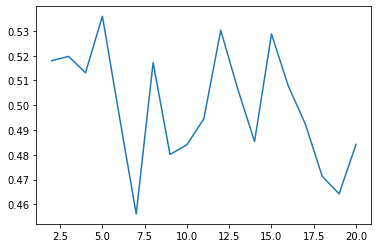

In [ ]:
plot_optimal_topic_num(results)

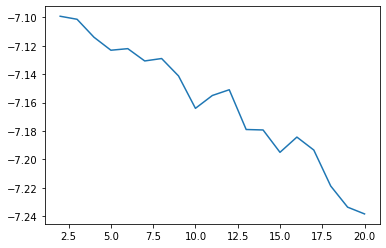

In [ ]:
plot_optimal_topic_num_perp(results)

In [ ]:
# BOW model on negative reviews
vis = visualize_optimal_lda_model(corpus, 8)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.254434  0.016553       1        1  57.510917
0     -0.112318  0.057384       2        1  11.014601
7     -0.166469  0.139882       3        1   8.128405
6     -0.049145 -0.190591       4        1   7.856996
5      0.019639 -0.169858       5        1   6.705295
2      0.171828  0.038073       6        1   3.296160
1      0.190370  0.039203       7        1   3.171855
3      0.200528  0.069353       8        1   2.315770, topic_info=           Term         Freq        Total Category  logprob  loglift
38        movie  4802.000000  4802.000000  Default  30.0000  30.0000
23         film  1698.000000  1698.000000  Default  29.0000  29.0000
6           bad  1660.000000  1660.000000  Default  28.0000  28.0000
34       matrix  2955.000000  2955.000000  Default  27.0000  27.0000
272           t  1486.000000  1486.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1450  political     5.628660    22.444789   Topic8  -5.8720   2.3822
6           bad    10.610525  1660.339649   Topic8  -5.2380  -1.2875
238       close     6.262159    64.294151   Topic8  -5.7653   1.4365
49        power     6.038299   111.203518   Topic8  -5.8017   0.8522
120        plot     5.670072   464.967324   Topic8  -5.8646  -0.6413

[565 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
72        1  0.501925      1st
72        3  0.250962      1st
72        6  0.225866      1st
144       8  0.912767  20_year
1402      6  0.818930    30min
...     ...       ...      ...
609       4  0.120025     year
609       5  0.148603     year
609       6  0.017146     year
1014      2  0.970224     zion
5374      8  0.818274        😞

[947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 8, 7, 6, 3, 2, 4])

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

**Experimentation with tfidf instead of bow**

In [ ]:
tfidf_model = TfidfModel(corpus, normalize=True)

In [ ]:
tfidf_corpus = [tfidf_model[corpus[i]] for i in range(len(corpus))]

In [ ]:
max_topic = 15 #comment when max topic is actually computed
lda_model_tfidf_s15 = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=max_topic, 
                                           update_every=1,
                                           chunksize=1000,
                                           passes=100,
                                           iterations=20)

In [ ]:
# TFIDF model on all reviews dataset
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf_s15, tfidf_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_shawshank_tfidf_15_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.422489  0.003034       1        1  55.265750
2      0.027024  0.315789       2        1   8.455142
13     0.055108 -0.018884       3        1   3.781883
4     -0.001484 -0.056246       4        1   3.425230
9     -0.097595 -0.024714       5        1   3.264579
10     0.083095 -0.008912       6        1   3.251217
0     -0.022057 -0.022318       7        1   3.142055
5      0.019972 -0.037076       8        1   2.984173
1      0.072353 -0.025190       9        1   2.776046
7     -0.020475 -0.017765      10        1   2.650390
14     0.078939 -0.021989      11        1   2.530156
12     0.076084 -0.018203      12        1   2.280376
3      0.025185 -0.029793      13        1   2.262027
8      0.063765 -0.022873      14        1   2.042988
11     0.062576 -0.014860      15        1   1.887987, topic_info=            Term        Freq       Total Category  logprob  loglift
9           good  414.000000  414.000000  Default  30.0000  30.0000
80         great  314.000000  314.000000  Default  29.0000  29.0000
26          time  311.000000  311.000000  Default  28.0000  28.0000
28         watch  248.000000  248.000000  Default  27.0000  27.0000
96          love  159.000000  159.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
4751      honour    1.058891    1.786929  Topic15  -6.5083   3.4464
5004         gay    0.899884    1.627926  Topic15  -6.6710   3.3769
771   resolution    1.729722    3.263888  Topic15  -6.0176   3.3347
3750       pulse    0.805776    1.533814  Topic15  -6.7815   3.3260
96          love   31.751938  159.519365  Topic15  -3.1076   2.3554

[675 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2458     10  0.464464      142_minute
3805      6  0.875731             1st
3327     12  0.775874             2nd
548       9  0.884921  ability_result
893      12  0.816404         account
...     ...       ...             ...
258       1  0.787343            year
258       5  0.181694            year
258       7  0.026918            year
5022     10  0.457464           youth
4193     14  0.881901         youtube

[836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 14, 5, 10, 11, 1, 6, 2, 8, 15, 13, 4, 9, 12])

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model_s15, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.5500423442518411


**NMF**

In [38]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 59.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [39]:
from gensim.models.nmf import Nmf
nmf_model = Nmf(corpus, num_topics=15, kappa=0.1, eval_every=1, chunksize=1000, id2word=id2word)
nmf_model.print_topics()

[(0,
  '0.121*"prison" + 0.035*"story" + 0.022*"friendship" + 0.016*"wife" + 0.016*"year" + 0.011*"way" + 0.011*"end" + 0.011*"character" + 0.010*"murder" + 0.010*"sense"'),
 (1,
  '0.085*"time" + 0.066*"story" + 0.039*"great" + 0.028*"performance" + 0.018*"character" + 0.013*"perfect" + 0.013*"actor" + 0.012*"drama" + 0.010*"favorite" + 0.009*"watch"'),
 (2,
  '0.577*"good" + 0.018*"picture" + 0.010*"frenetic" + 0.009*"work" + 0.009*"role" + 0.008*"touch" + 0.008*"friend" + 0.008*"way" + 0.007*"brilliant" + 0.006*"great"'),
 (3,
  '0.054*"hope" + 0.039*"people" + 0.032*"life" + 0.022*"time" + 0.013*"world" + 0.012*"freedom" + 0.012*"day" + 0.012*"well" + 0.012*"word" + 0.009*"love"'),
 (4,
  '0.028*"character" + 0.024*"man" + 0.018*"human" + 0.018*"prisoner" + 0.012*"bad" + 0.008*"way" + 0.008*"world" + 0.008*"emotion" + 0.007*"audience" + 0.007*"freedom"'),
 (5,
  '0.348*"good" + 0.163*"nice" + 0.029*"life" + 0.027*"actor" + 0.014*"performance" + 0.014*"man" + 0.009*"end" + 0.009*"ro

In [40]:
coherence_model_lda = CoherenceModel(model=nmf_model, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.5086690095684413
